In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('movies_metadata.csv')
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [3]:
df.isnull().sum() #checking the null values

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

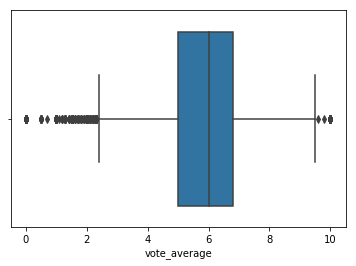

In [4]:
sns.boxplot(df['vote_average']) #checking the outlier of Vote_average

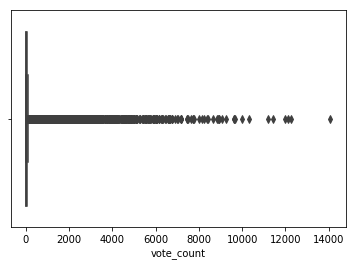

In [5]:
sns.boxplot(df['vote_count']) #checking the outliers of vote_count

In [6]:
#FINDING OUTLIERS USING INTERQUARTILE RANGE
Q1 =  df['vote_average'].quantile(0.25)
Q3 = df['vote_average'].quantile(0.75)
IQR = Q3 - Q1

In [7]:
#REMOVING THE OUTLIERS
df = df[~((df['vote_average'] < (Q1 - 1.5 * IQR)) | (df['vote_average'] > (Q3 + 1.5 * IQR)))]

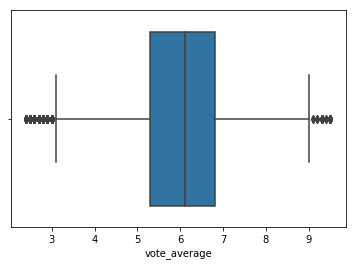

In [8]:
sns.boxplot(df['vote_average']) #now the outliers are removed

In [9]:
#TOP RECOMMENDER 

In [10]:
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [11]:
#NETFLIX WEIGHTED RATING FORMULA TO FIND TOP CHART
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int') #REMOVING MISSING VALUES
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int') #REMOVING MISSING VALUES
C = vote_averages.mean() #C = Mean vote accross the whole dataset

m = vote_counts.quantile(0.90) #m = minimum vote required to be listed in TOP CHART
#Select movie rating which has ABOVE 90% vote count

top_C = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'release_date', 'vote_count', 'vote_average', 'popularity', 'genres']]
top_C['vote_count'] = top_C['vote_count'].astype('int')
top_C['vote_average'] = top_C['vote_average'].astype('int')
top_C.shape

(4200, 6)

In [12]:
#NETFLIX WEIGHTED RATING FORMULA 
#C = Mean vote accross the whole dataset
#m = minimum vote required to be listed in TOP CHART
#v = total vote of a particular movie
#R = average vote of a particular movie
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v + m) * R) + (m/(m + v) * C)

In [13]:
#Adding and Applying Weighted Rating to the TOP CHART 
top_C['weighted_rate'] = top_C.apply(weighted_rating, axis = 1)
top_C = top_C.sort_values('weighted_rate', ascending = False).head(300) #top 300 movies
top_C.head()

,title,release_date,vote_count,vote_average,popularity,genres,weighted_rate
10309,Dilwale Dulhania Le Jayenge,1995-10-20,661,9,34.457,"[Comedy, Drama, Romance]",8.270628
15480,Inception,2010-07-14,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.969660
12481,The Dark Knight,2008-07-16,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.965259
22879,Interstellar,2014-11-05,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.961953
2843,Fight Club,1999-10-15,9678,8,63.8696,[Drama],7.956131


In [14]:
#Now we also wants to make genre wise movie top chart
series = df.apply(lambda x: pd.Series(x['genres']), axis = 1).stack().reset_index(level = 1, drop = True)
series.name = 'genre' #making a series array (column) of genre with movie id 
genre_df = df.drop('genres', axis = 1).join(series) #joining series array (column) to the dataframe of movie
genre_df.head() #it will help us to find the movie by typing the genre

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Fantasy


In [15]:
#Making a function that will return the top chart movies of the particular genre
#we will use 90% qualifying movie of that genre
def Top_C_Genre(genre):
    df1 = genre_df[genre_df['genre'] == genre]
    vote_counts = df1[df1['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df1[df1['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.90)
    top = df1[(df1['vote_count'] >= m) & (df1['vote_count'].notnull()) & (df1['vote_average'].notnull())][['title', 'release_date', 'vote_count', 'vote_average', 'popularity']]
    top['vote_count'] = top['vote_count'].astype('int')
    top['vote_average'] = top['vote_average'].astype('int')
    top['weighted_rate'] = top.apply(weighted_rating, axis = 1)
    top = top.sort_values('weighted_rate', ascending = False).head(300)
    return top

In [16]:
genre = input("Enter your favourite genre: ") 
Top_C_Genre(genre)
#Generate 300 top chart of user input genre

Enter your favourite genre: Comedy


,title,release_date,vote_count,vote_average,popularity,weighted_rate
10309,Dilwale Dulhania Le Jayenge,1995-10-20,661,9,34.457,8.270628
351,Forrest Gump,1994-07-06,8147,8,48.3072,7.948068
1225,Back to the Future,1985-07-03,6239,8,25.7785,7.932639
18465,The Intouchables,2011-11-02,5410,8,16.0869,7.922655
22841,The Grand Budapest Hotel,2014-02-26,4644,8,14.442,7.910381
2211,Life Is Beautiful,1997-12-20,3643,8,39.395,7.886934
732,Dr. Strangelove or: How I Learned to Stop Worr...,1964-01-29,1472,8,9.80398,7.738616
3342,Modern Times,1936-02-05,881,8,8.15956,7.593430
883,Some Like It Hot,1959-03-18,835,8,11.8451,7.575059
1236,The Great Dictator,1940-10-15,756,8,9.24175,7.539307


In [17]:
#COLLABORATIVE FILTERING APPROACH USING KNN
#this will predict the best movie using rating dataset that merge with movie dataset. 
#we now no longer need vote average, vote count or weighted ratings

In [18]:
ratings_df = pd.read_csv("ratings.csv") #we will use the rating dataset with movie set to find the collaborative filtering

In [19]:
movie_df = pd.read_csv("movies_metadata.csv") #We are again importing movie dataset because column 
                                                #id was not converting into integer format

In [20]:
#there are still some invalid literal which does not allow us to index the id field
movie_df.drop(movie_df.index[19730], inplace = True)
movie_df.drop(movie_df.index[29502], inplace = True)
movie_df.drop(movie_df.index[35585], inplace = True)
movie_df.id = movie_df.id.astype(np.int64) #converting column id from float into integer 
movie_df.shape

(45463, 24)

In [21]:
#making a rating dataframe join with movie title, id and genre
ratings_df = pd.merge(ratings_df, movie_df[['title', 'id', 'genres']], left_on = 'movieId', right_on = 'id')
ratings_df.drop(['timestamp', 'id'], axis = 1, inplace = True) #no need of timestamp and id
ratings_df.shape

(44994, 5)

In [22]:
ratings_df.isnull().sum() #checking if there

userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

In [23]:
#checking the total rating count of each movie
ratings_count = ratings_df.groupby(by = "title")['rating'].count().reset_index().rename(columns={'rating':'totalRatings'})[['title', 'totalRatings']]
ratings_count.shape

(2794, 2)

In [24]:
#joining the count rate dataframe with raing dataset
ratings_df['genres'] = ratings_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
ratings_total = pd.merge(ratings_df, ratings_count, on = 'title', how = 'left')
ratings_total.shape

(44994, 6)

In [25]:
#checking duplicates and find those titles which have more than 10 rate count
top_rate = ratings_total.query('totalRatings > 10')
if not top_rate[top_rate.duplicated(['userId', 'title'])].empty:
    top_rate = top_rate.drop_duplicates(['userId', 'title'])
top_rate.shape

(38992, 6)

In [26]:
#make a dataframe for sparse matrix that has index as title, columns as users and value as raitng
df2 = top_rate.pivot(index = 'title', columns = 'userId',values = 'rating').fillna(0)
df2.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
10 Items or Less,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2 Days in Paris,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"20,000 Leagues Under the Sea",0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
24 Hour Party People,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Use KNN to find recommend movies
def Recommendation_KNN(title):
    df2_sparse = csr_matrix(df2.values) #make a sparse matrix
    knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 20, n_jobs = -1)
    knn.fit(df2_sparse) #fit the model
    distances, indices = knn.kneighbors(df2.iloc[title, :].values.reshape(1, -1), n_neighbors = 10 + 1) #calculating the distance according to rating with k = 10
    k = range(0, len(distances.flatten()))
    k_title = indices.flatten()
    for i in k:
        if i == 0:
            print("Top 10 Movie According with: {0}\n".format(df2.index[title]))
        else:
            print("{0}: {1}".format(i,df2.index[k_title[i]]))

In [28]:
Recommendation_KNN(207)

Top 10 Movie According with: Die Hard 2

1: Parenthood
2: Who Killed Bambi?
3: Y Tu Mamá También
4: Rope
5: La Vie en Rose
6: Silent Light
7: Rambo III
8: Aguirre: The Wrath of God
9: Say Anything...
10: When Saturday Comes
